# Machine Learning Approach based on UNet

In [ ]:
# Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import *
from keras.metrics import *
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:
# Chech GPU - Colab Pro
import os
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(f"Using GPU is CUDA:{os.environ['CUDA_VISIBLE_DEVICES']}")

for i in range(torch.cuda.device_count()):
    info = torch.cuda.get_device_properties(i)
    print(f"CUDA:{i} {info.name}, {info.total_memory / 1024 ** 2}MB")

device = torch.device("cuda:0")

Using GPU is CUDA:0
CUDA:0 A100-SXM4-40GB, 40536.1875MB


In [ ]:
class AppleCounting():
  def __init__(self):
    self.datagenTrain = ImageDataGenerator(validation_split = 0.65)
    self.datagenValid = ImageDataGenerator(validation_split = 0.5)
    self.datagen = ImageDataGenerator()
    self.autotune = AUTOTUNE = tf.data.experimental.AUTOTUNE
    return

  def load_data(self):
    print("... Data loading ...")
    # prepare an iterators for each dataset
    # images are converted to grayscale first to reduce training time
    # for traning data, we have +64k images, we set a validation_split to only use 45%
    path = '/content/drive/My Drive/mldata_full/train'
    self.trainData = self.datagenTrain.flow_from_directory(path, shuffle=True, class_mode="categorical", target_size=(224, 224),
                                                   subset='training', color_mode = 'grayscale', batch_size = 64)
    # for validation data, we have +3.9k images, we set a validation split to only use 50%
    path = '/content/drive/My Drive/mldata_full/valid'
    self.validData = self.datagenValid.flow_from_directory(path, shuffle=True, class_mode="categorical", target_size=(224, 224),
                                                   subset='validation', color_mode = 'grayscale', batch_size = 64)
    # the test dataset is fully loaded
    path = '/content/drive/My Drive/mldata/test'
    self.testData = self.datagen.flow_from_directory(path, shuffle=True, class_mode="categorical", target_size=(224, 224), 
                                                     color_mode = 'grayscale', batch_size = 64)
    print("... Done ...")
    return

  def preprocess_data(self):
    print("... Pre processing data ...")
    self.trainData = (self.trainData.map(toFloat).cache().prefetch(buffer_size=self.autotune))
    self.validData = (self.validData.map(toFloat).cache().prefetch(buffer_size=self.autotune))
    self.testData = (self.testData.map(toFloat).cache().prefetch(buffer_size=self.autotune))
    print("... Done ...")
    return

  def get_unet(self, IMG_WIDTH=224,IMG_HEIGHT=224,IMG_CHANNELS=1):
    print("... Building UNet ...")
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = BatchNormalization() (c1)
    c1 = Dropout(0.4) (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = BatchNormalization() (c2)
    c2 = Dropout(0.4) (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = BatchNormalization() (c3)
    c3 = Dropout(0.4) (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = BatchNormalization() (c4)
    c4 = Dropout(0.4) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = BatchNormalization() (c5)
    c5 = Dropout(0.4) (c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization() (c6)
    c6 = Dropout(0.4) (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = BatchNormalization() (c7)
    c7 = Dropout(0.4) (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = BatchNormalization() (c8)
    c8 = Dropout(0.4) (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = BatchNormalization() (c9)
    c9 = Dropout(0.4) (c9)
    
    d11 = Flatten() (c9)

    outputs = Dense(4, activation='softmax') (d11)
    self.model = Model(inputs=[inputs], outputs=[outputs])
    print("... Compiling UNet ...")
    self.model.compile(optimizer='adam',loss='categorical_crossentropy', metrics =['accuracy', 'mae'])
    print("... Done ...")
    return

  def train(self):
    self.history = self.model.fit(self.trainData, 
                                  validation_data = self.validData,
                                  steps_per_epoch = self.trainData.n//self.trainData.batch_size,
                                  validation_steps = self.validData.n//self.validData.batch_size,
                                  epochs=30, verbose=1)
    return

def toFloat(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label


In [ ]:
# load data
ac = AppleCounting()
ac.load_data()

... Data loading ...
Found 12919 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
... Done ...


In [ ]:
# compile the model
ac.get_unet()
ac.model.summary()

... Building UNet ...
... Compiling UNet ...
... Done ...
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 224, 224, 1)  0           ['input_20[0][0]']               
                                                                                                  
 conv2d_171 (Conv2D)            (None, 224, 224, 16  160         ['lambda_3[0][0]']               
                                )                                                                 
                                 

In [ ]:
# train the model
ac.train()

Epoch 1/30
201/201 [==============================] - 150s 744ms/step - loss: 11.6029 - accuracy: 0.4509 - mae: 0.2754 - val_loss: 14.4066 - val_accuracy: 0.3052 - val_mae: 0.3484
Epoch 2/30
201/201 [==============================] - 22s 109ms/step - loss: 8.6302 - accuracy: 0.6070 - mae: 0.1960 - val_loss: 10.0457 - val_accuracy: 0.4000 - val_mae: 0.3005
Epoch 3/30
201/201 [==============================] - 22s 109ms/step - loss: 5.1560 - accuracy: 0.7241 - mae: 0.1385 - val_loss: 10.4364 - val_accuracy: 0.4635 - val_mae: 0.2666
Epoch 4/30
201/201 [==============================] - 22s 111ms/step - loss: 3.1392 - accuracy: 0.7958 - mae: 0.1022 - val_loss: 12.8492 - val_accuracy: 0.4542 - val_mae: 0.2716
Epoch 5/30
201/201 [==============================] - 22s 109ms/step - loss: 1.9920 - accuracy: 0.8398 - mae: 0.0802 - val_loss: 13.1749 - val_accuracy: 0.5146 - val_mae: 0.2419
Epoch 6/30
201/201 [==============================] - 22s 111ms/step - loss: 1.2958 - accuracy: 0.8786 - mae

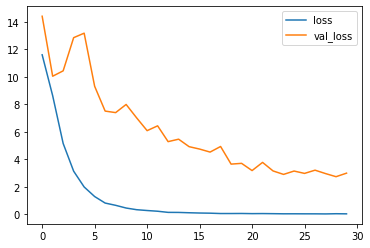

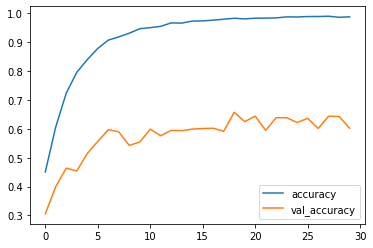

In [ ]:
# get loss and accuracy graphs
history_frame = pd.DataFrame(ac.history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
ac.model.evaluate(ac.testData)

5/5 [==============================] - 1s 86ms/step - loss: 3.8110 - accuracy: 0.6154 - mae: 0.1953


[3.8109724521636963, 0.6153846383094788, 0.19530797004699707]

In [ ]:
datagen = ImageDataGenerator()
path = '/content/drive/My Drive/mldata/tests/test'
results = []
for i in range(11):
  pathX = path + str(i+1)
  testData = datagen.flow_from_directory(pathX, shuffle=False, class_mode="categorical", target_size=(224, 224), 
                                                     color_mode = 'grayscale')
  results.append(ac.model.evaluate(testData))

for i in results:
  print(i)

Found 50 images belonging to 1 classes.
2/2 [==============================] - 0s 26ms/step - loss: 36.9119 - accuracy: 0.8200 - mae: 0.7500
Found 50 images belonging to 1 classes.
2/2 [==============================] - 0s 28ms/step - loss: 58.4363 - accuracy: 0.8200 - mae: 0.7500
Found 50 images belonging to 1 classes.
2/2 [==============================] - 15s 15s/step - loss: 58.8302 - accuracy: 0.9000 - mae: 0.7500
Found 13 images belonging to 1 classes.
1/1 [==============================] - 0s 216ms/step - loss: 65.7865 - accuracy: 0.8462 - mae: 0.7500
Found 21 images belonging to 1 classes.
1/1 [==============================] - 0s 74ms/step - loss: 33.5796 - accuracy: 0.6190 - mae: 0.7500
Found 21 images belonging to 1 classes.
1/1 [==============================] - 0s 79ms/step - loss: 30.5182 - accuracy: 0.5714 - mae: 0.7500
Found 21 images belonging to 1 classes.
1/1 [==============================] - 0s 78ms/step - loss: 48.5821 - accuracy: 0.4762 - mae: 0.7500
Found 5 imag

# Machine Learning Approach based on CNNs and Dense Layers

In [ ]:
# Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPool2D
import math, re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import os
import tensorflow as tf
import numpy as np

In [ ]:
### read the groundtruth json file
import json
with open('/content/drive/My Drive/ground_truth.json', 
          'r') as f:
    ground_truth = json.load(f)

pd1 = pd.DataFrame(ground_truth, index=[0])
pd1["testset2_931cluster_8_count0.png"] #verify input is correct

0    2
Name: testset2_931cluster_8_count0.png, dtype: object

In [ ]:
# A function for verification to ensure the labels are correctly read 
def readLabels(path):
  filenames = []
  for root, dirs, files in os.walk(path, topdown=True):
    for name in files:
      filenames.append(name)
  
  labels = []
  for i in range(len(filenames)):
    strSub = (filenames)[i]
    labels.append(strSub)
  return labels

train_labels =  readLabels("/content/drive/My Drive/ml")
valid_labels = readLabels('/content/drive/My Drive/mlvalid/')
test_labels = readLabels('/content/drive/My Drive/mltest/')


valid_labels_values = pd1[valid_labels] ##pd1 is the json groundtruth 
test_labels_values = pd1[test_labels]
train_labels_values = pd1[train_labels]

train_labels_values = list([int(x) for x in ((train_labels_values.values)[0]) ])
train_labels_values[:5] #show the first 5 values

test_labels_values = list([int(x) for x in ((test_labels_values.values)[0]) ])
test_labels_values[:5] #show the first 5 values

valid_labels_values = list([int(x) for x in ((valid_labels_values.values)[0]) ])
valid_labels_values[:5] #show the first 5 values

[3, 1, 2, 1, 3]

In [ ]:
# Load the training, validation and testing sets from drive
trainset = image_dataset_from_directory(
    '/content/drive/My Drive/ml/',
    labels=train_labels_values,
    label_mode='int',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=16,
    color_mode = "grayscale",
    shuffle=False,
)

validset = image_dataset_from_directory(
    '/content/drive/My Drive/mlvalid/',
    labels=valid_labels_values,
    label_mode='int',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=16,
    color_mode = "grayscale",
    shuffle=False,
)

testsetdata = image_dataset_from_directory(
    '/content/drive/My Drive/mltest/',
    labels=test_labels_values,
    label_mode='int',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=16,
    color_mode = "grayscale",
    shuffle=False,
)

def toFloat(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
trainset = (trainset.map(toFloat).cache().prefetch(buffer_size=AUTOTUNE))
validset = (validset.map(toFloat).cache().prefetch(buffer_size=AUTOTUNE))
testsetdata = (testsetdata.map(toFloat).cache().prefetch(buffer_size=AUTOTUNE))

Found 2240 files belonging to 1 classes.
Found 280 files belonging to 1 classes.
Found 275 files belonging to 1 classes.


In [ ]:
##convolutional NN
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(224, 224, 1)))
model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(MaxPool2D((2,2), strides=(2,2)))

# fully-connected layer
model.add(Flatten())

model.add(Dense(6))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.8))

model.add(Dense(64))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))  
model.add(Activation("softmax")) # softmax classifier
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_180 (Conv2D)         (None, 224, 224, 256)     2560      
                                                                 
 conv2d_181 (Conv2D)         (None, 224, 224, 64)      147520    
                                                                 
 conv2d_182 (Conv2D)         (None, 222, 222, 32)      18464     
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 394272)            0         
                                                                 
 dense_28 (Dense)            (None, 6)                 2365638   
                                                        

In [ ]:
model.compile(optimizer='adam', 
              loss='mae',
              metrics=['accuracy', 'mae'],
              )
history = model.fit(trainset, validation_data=validset, epochs=10, verbose=2, 
                    batch_size = 128)

Epoch 1/10
140/140 - 45s - loss: 0.3433 - accuracy: 0.7308 - mae: 0.3433 - val_loss: 0.4393 - val_accuracy: 0.6679 - val_mae: 0.4393 - 45s/epoch - 318ms/step
Epoch 2/10
140/140 - 4s - loss: 0.3433 - accuracy: 0.7308 - mae: 0.3433 - val_loss: 0.4393 - val_accuracy: 0.6679 - val_mae: 0.4393 - 4s/epoch - 31ms/step
Epoch 3/10
140/140 - 4s - loss: 0.3433 - accuracy: 0.7308 - mae: 0.3433 - val_loss: 0.4393 - val_accuracy: 0.6679 - val_mae: 0.4393 - 4s/epoch - 31ms/step
Epoch 4/10
140/140 - 4s - loss: 0.3433 - accuracy: 0.7308 - mae: 0.3433 - val_loss: 0.4393 - val_accuracy: 0.6679 - val_mae: 0.4393 - 4s/epoch - 31ms/step
Epoch 5/10
140/140 - 4s - loss: 0.3433 - accuracy: 0.7308 - mae: 0.3433 - val_loss: 0.4393 - val_accuracy: 0.6679 - val_mae: 0.4393 - 4s/epoch - 31ms/step
Epoch 6/10
140/140 - 4s - loss: 0.3433 - accuracy: 0.7308 - mae: 0.3433 - val_loss: 0.4393 - val_accuracy: 0.6679 - val_mae: 0.4393 - 4s/epoch - 31ms/step
Epoch 7/10
140/140 - 4s - loss: 0.3433 - accuracy: 0.7308 - mae: 0.

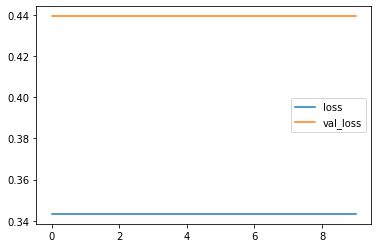

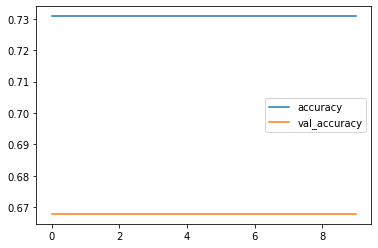

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
model.evaluate(testsetdata, verbose=2)

18/18 - 0s - loss: 0.3564 - accuracy: 0.7091 - mae: 0.3564 - 221ms/epoch - 12ms/step


[0.3563636243343353, 0.7090908885002136, 0.3563636243343353]

In [ ]:
datagen = ImageDataGenerator()
path = '/content/drive/My Drive/mldata/tests/test'
resultsCnn = []
resultsUnet = []
for i in range(11):
  pathX = path + str(i+1)
  testData = datagen.flow_from_directory(pathX, shuffle=False, class_mode="categorical", target_size=(224, 224), 
                                                     color_mode = 'grayscale')
  resultsCnn.append(model.evaluate(testData))
  resultsUnet.append(ac.model.evaluate(testData))


Found 50 images belonging to 1 classes.
2/2 [==============================] - 0s 26ms/step - loss: 36.9119 - accuracy: 0.8200 - mae: 0.7500
Found 50 images belonging to 1 classes.
2/2 [==============================] - 0s 25ms/step - loss: 58.4363 - accuracy: 0.8200 - mae: 0.7500
Found 50 images belonging to 1 classes.
2/2 [==============================] - 0s 23ms/step - loss: 58.8302 - accuracy: 0.9000 - mae: 0.7500
Found 13 images belonging to 1 classes.
1/1 [==============================] - 0s 58ms/step - loss: 65.7865 - accuracy: 0.8462 - mae: 0.7500
Found 21 images belonging to 1 classes.
1/1 [==============================] - 0s 72ms/step - loss: 33.5796 - accuracy: 0.6190 - mae: 0.7500
Found 21 images belonging to 1 classes.
1/1 [==============================] - 0s 80ms/step - loss: 30.5182 - accuracy: 0.5714 - mae: 0.7500
Found 21 images belonging to 1 classes.
1/1 [==============================] - 0s 77ms/step - loss: 48.5821 - accuracy: 0.4762 - mae: 0.7500
Found 5 image

In [ ]:
datagen2 = ImageDataGenerator()
path2 = '/content/drive/My Drive/mldata/test'

testData2 = datagen2.flow_from_directory(path2, shuffle=False, class_mode="categorical", target_size=(224, 224), 
                                                    color_mode = 'grayscale')
print("CNN")
model.evaluate(testData2)
print("Unet")
ac.model.evaluate(testData2)


Found 273 images belonging to 4 classes.
CNN
9/9 [==============================] - 0s 41ms/step - loss: 0.7500 - accuracy: 0.2500 - mae: 0.7500
Unet
9/9 [==============================] - 0s 44ms/step - loss: 3.8110 - accuracy: 0.6154 - mae: 0.1953


[3.811037063598633, 0.6153846383094788, 0.1953071653842926]

In [ ]:
for i in resultsCnn:
  print(i)

[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]
[0.0, 1.0, 0.0]


In [ ]:
for i in resultsUnet:
  print(i)

[36.91189956665039, 0.8199999928474426, 0.75]
[58.4362907409668, 0.8199999928474426, 0.75]
[58.83015441894531, 0.8999999761581421, 0.75]
[65.78648376464844, 0.8461538553237915, 0.75]
[33.579559326171875, 0.6190476417541504, 0.75]
[30.518203735351562, 0.5714285969734192, 0.75]
[48.582061767578125, 0.4761904776096344, 0.75]
[47.69849395751953, 0.800000011920929, 0.75]
[36.58333969116211, 0.380952388048172, 0.75]
[41.83425521850586, 0.375, 0.75]
[35.37382507324219, 0.0, 0.75]
